In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook

import fannypack
from lib import panda_datasets, panda_baseline_models, panda_baseline_training
from lib.ekf import KalmanFilterNetwork
from fannypack import utils
from lib import dpf
from lib.panda_models import PandaDynamicsModel, PandaEKFMeasurementModel
from lib.fusion import CrossModalWeights
import lib.panda_kf_training as training
from lib.fusion import KalmanFusionModel



In [6]:
# Experiment configuration
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [17]:
experiment_names = ["fusion_sigma_final_0", "fusion_weighted_final_0", "fusion_poe_final_0", "fusion_poe_1000_hu64_1loss"]
fusion_type = ["sigma", "weighted", "poe", "poe"]


In [26]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

# eval_trajectories = eval_trajectories[70:90]

In [18]:
# image_modality_model
image_measurement = PandaEKFMeasurementModel(missing_modalities=['gripper_sensors'], units=64)
image_dynamics = PandaDynamicsModel(use_particles=False)
image_model = KalmanFilterNetwork(image_dynamics, image_measurement)

# force_modality_model
force_measurement = PandaEKFMeasurementModel(missing_modalities=['image'], units=64)
force_dynamics = PandaDynamicsModel(use_particles=False)
force_model = KalmanFilterNetwork(force_dynamics, force_measurement)

weight_model = CrossModalWeights()

fusion_models = []
buddies = []

for i, f_type in enumerate(fusion_type):
    model = KalmanFusionModel(image_model, force_model, weight_model, fusion_type=f_type)
    buddy = fannypack.utils.Buddy(experiment_names[i],
                                  model,
                                optimizer_names=["im_meas", "force_meas",
                                "im_dynamics", "force_dynamics",
                                "force_ekf", "im_ekf",
                                "fusion"],
                                  load_checkpoint=True,
                                  )
    buddy.load_model("phase_4_fusion")
    fusion_models.append(model)
    buddies.append(buddy)



[buddy-fusion_sigma_final_0] Using device: cuda
[buddy-fusion_sigma_final_0] Loaded metadata: {'batch': 128, 'epochs': 5, 'hidden_units': 64, 'image_blackout_ratio': 0.0, 'init state noise': 0.4, 'loading checkpoint': None, 'many loss': False, 'omnipush dataset': False, 'pretrain epochs': 5, 'start training from': 'fusion', 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-fusion_sigma_final_0] Read checkpoint from path: checkpoints/fusion_sigma_final_0-0000000000088145.ckpt
[buddy-fusion_sigma_final_0] Loaded checkpoint at step: 88145
[buddy-fusion_weighted_final_0] Using device: cuda
[buddy-fusion_weighted_final_0] Loaded metadata: {'batch': 128, 'epochs': 5, 'hidden_units': 64, 'image_blackout_ratio': 0.0, 'init state noise': 0.4, 'loading checkpoint': None, 'many loss': False, 'omnipush dataset': False, 'pretrain epochs': 5, 'start training from': 'fusion', 'use_haptics': True, 'use_mass': False, 'use_proprioception

/scr-ssd/filter/fannypack/fannypack/utils/_buddy_mixins/_checkpointing.py:252: UserWarning: Checkpoint loading: overriding optimizer names.
  warnings.warn("Checkpoint loading: overriding optimizer names.")


[buddy-fusion_weighted_final_0] Read checkpoint from path: checkpoints/fusion_weighted_final_0-0000000000088145.ckpt
[buddy-fusion_weighted_final_0] Loaded checkpoint at step: 88145
[buddy-fusion_poe_final_0] Using device: cuda
[buddy-fusion_poe_final_0] Loaded metadata: {'batch': 128, 'epochs': 5, 'hidden_units': 64, 'image_blackout_ratio': 0.0, 'init state noise': 0.4, 'loading checkpoint': None, 'many loss': False, 'omnipush dataset': False, 'pretrain epochs': 5, 'start training from': 'fusion', 'use_haptics': True, 'use_mass': False, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-fusion_poe_final_0] Read checkpoint from path: checkpoints/fusion_poe_final_0-0000000000086965.ckpt
[buddy-fusion_poe_final_0] Loaded checkpoint at step: 86965
[buddy-fusion_poe_1000_hu64_1loss] Using device: cuda
[buddy-fusion_poe_1000_hu64_1loss] Read checkpoint from path: checkpoints/fusion_poe_1000_hu64_1loss-0000000000080000.ckpt
[buddy-fusion_poe_1000_hu64_1loss] Loaded 

In [19]:
# # image_modality_model
# image_measurement = PandaEKFMeasurementModel(missing_modalities=['gripper_sensors'], units=128)
# image_dynamics = PandaDynamicsModel(use_particles=False)
# image_model = KalmanFilterNetwork(image_dynamics, image_measurement)

# # force_modality_model
# force_measurement = PandaEKFMeasurementModel(missing_modalities=['image'], units=128)
# force_dynamics = PandaDynamicsModel(use_particles=False)
# force_model = KalmanFilterNetwork(force_dynamics, force_measurement)

# weight_model = CrossModalWeights()

# fusion_models = []
# buddies = []

# f_type="poe"
# i = 2
# model = KalmanFusionModel(image_model, force_model, weight_model, fusion_type=f_type)
# buddy = fannypack.utils.Buddy(experiment_names[i],
#                               model,
#                             optimizer_names=["im_meas", "force_meas",
#                             "im_dynamics", "force_dynamics",
#                             "force_ekf", "im_ekf",
#                             "fusion"],
#                               load_checkpoint=True,
#                               )
# fusion_models.append(model)
# buddies.append(buddy)


[buddy-fusion_poe_1000_1loss] Using device: cuda
[buddy-fusion_poe_1000_1loss] No checkpoint found


[buddy-fusion_sigma_final_0] Read checkpoint from path: checkpoints/fusion_sigma_final_0-phase_4_fusion.ckpt
[buddy-fusion_sigma_final_0] Loaded checkpoint at step: 88145
[buddy-fusion_weighted_final_0] Read checkpoint from path: checkpoints/fusion_weighted_final_0-phase_4_fusion.ckpt
[buddy-fusion_weighted_final_0] Loaded checkpoint at step: 88145
[buddy-fusion_poe_final_0] Read checkpoint from path: checkpoints/fusion_poe_final_0-phase_4_fusion.ckpt
[buddy-fusion_poe_final_0] Loaded checkpoint at step: 86965
[buddy-fusion_poe_1000_hu64_1loss] Read checkpoint from path: checkpoints/fusion_poe_1000_hu64_1loss-phase_4_fusion.ckpt
[buddy-fusion_poe_1000_hu64_1loss] Loaded checkpoint at step: 87555
Fusion Model: poe
(10, 240, 2)


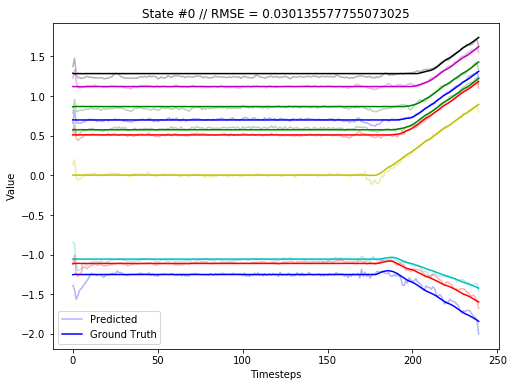

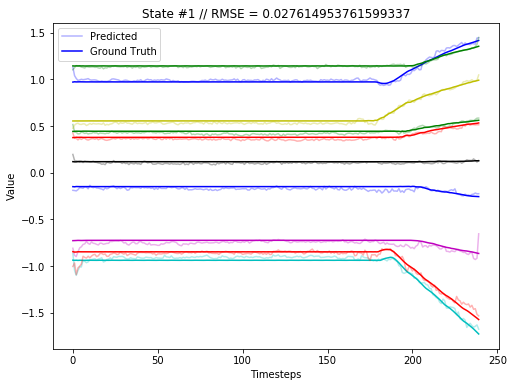

In [31]:

for i in range(len(fusion_models)):
    buddies[i].load_checkpoint("phase_4_fusion")
    if i != 3:
        continue
    print("Fusion Model: {}".format(fusion_type[i])) 
    pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, true_initial=True)
    training.eval_rollout(pred, actual, plot=True)
    print("")

[buddy-fusion_sigma_final_0] Read checkpoint from path: checkpoints/fusion_sigma_final_0-phase_4_fusion.ckpt
[buddy-fusion_sigma_final_0] Loaded checkpoint at step: 88145
Fusion Model: sigma
(10, 240, 2)


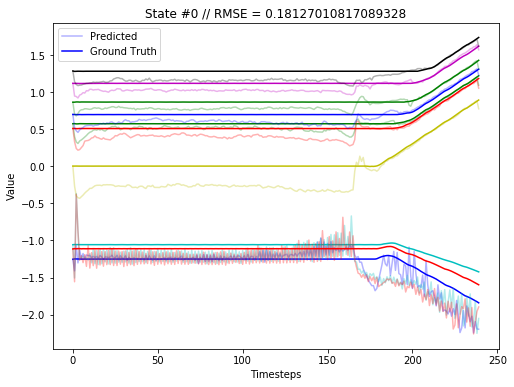

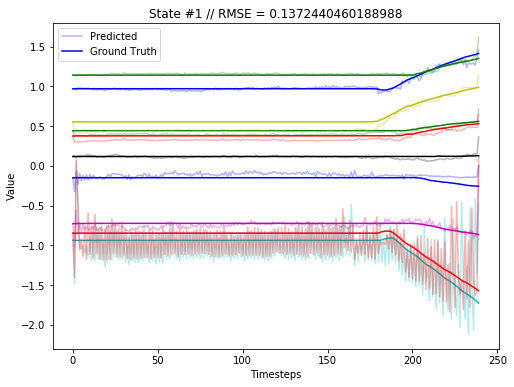


[buddy-fusion_weighted_final_0] Read checkpoint from path: checkpoints/fusion_weighted_final_0-phase_4_fusion.ckpt
[buddy-fusion_weighted_final_0] Loaded checkpoint at step: 88145
Fusion Model: weighted
(10, 240, 2)


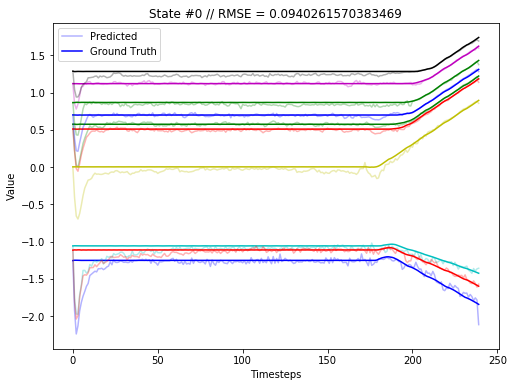

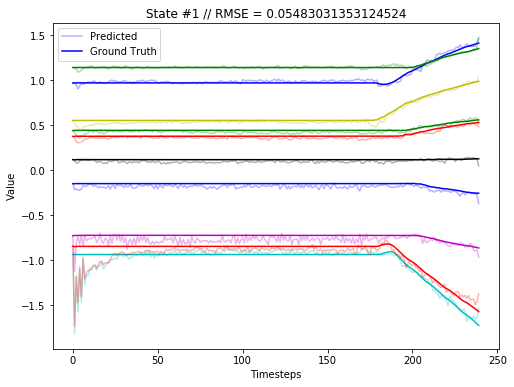


[buddy-fusion_poe_final_0] Read checkpoint from path: checkpoints/fusion_poe_final_0-phase_4_fusion.ckpt
[buddy-fusion_poe_final_0] Loaded checkpoint at step: 86965
Fusion Model: poe
(10, 240, 2)


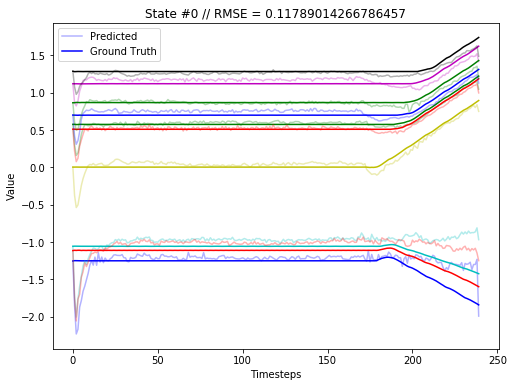

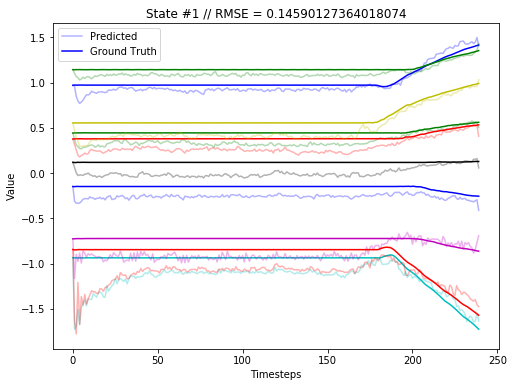


[buddy-fusion_poe_1000_hu64_1loss] Read checkpoint from path: checkpoints/fusion_poe_1000_hu64_1loss-phase_4_fusion.ckpt
[buddy-fusion_poe_1000_hu64_1loss] Loaded checkpoint at step: 87555
Fusion Model: poe
(10, 240, 2)


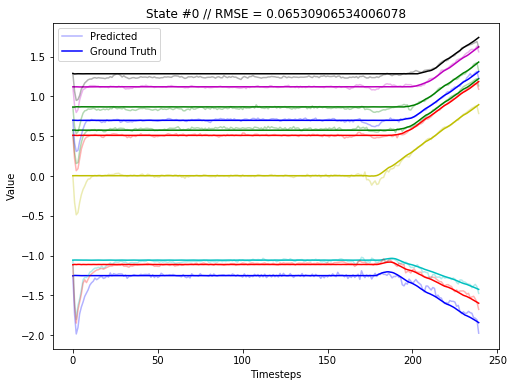

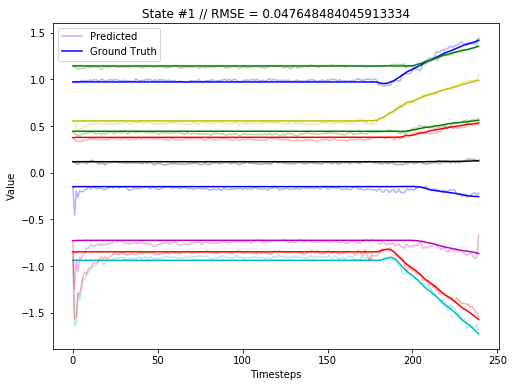

In [37]:

for i in range(len(fusion_models)):
    buddies[i].load_checkpoint("phase_4_fusion")

    print("Fusion Model: {}".format(fusion_type[i])) 
    pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, true_initial=True, init_state_noise=0.0)
    training.eval_rollout(pred, actual, plot=True)
    print("")

[buddy-fusion_sigma_final_0] Read checkpoint from path: checkpoints/fusion_sigma_final_0-phase_4_fusion.ckpt
[buddy-fusion_sigma_final_0] Loaded checkpoint at step: 88145
[buddy-fusion_weighted_final_0] Read checkpoint from path: checkpoints/fusion_weighted_final_0-phase_4_fusion.ckpt
[buddy-fusion_weighted_final_0] Loaded checkpoint at step: 88145
[buddy-fusion_poe_final_0] Read checkpoint from path: checkpoints/fusion_poe_final_0-phase_4_fusion.ckpt
[buddy-fusion_poe_final_0] Loaded checkpoint at step: 86965
[buddy-fusion_poe_1000_hu64_1loss] Read checkpoint from path: checkpoints/fusion_poe_1000_hu64_1loss-phase_4_fusion.ckpt
[buddy-fusion_poe_1000_hu64_1loss] Loaded checkpoint at step: 87555
Fusion Model: poe
(10, 240, 2)


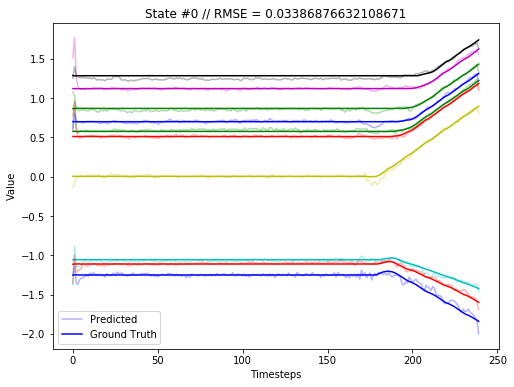

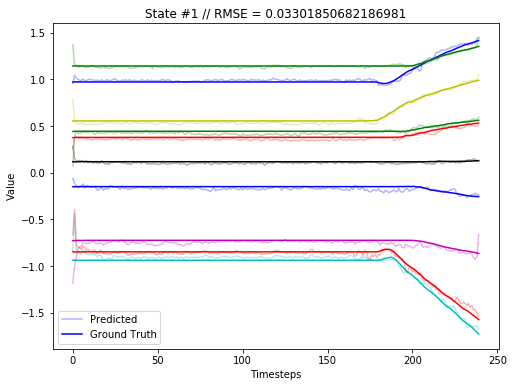

In [27]:

for i in range(len(fusion_models)):
    buddies[i].load_checkpoint("phase_4_fusion")

    print("Fusion Model: {}".format(fusion_type[i])) 
    pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, true_initial=True, init_state_noise=0.2)
    training.eval_rollout(pred, actual, plot=True)
    print("")

In [34]:
experiment_name = "ekf_1000_0"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}
measurement = PandaEKFMeasurementModel()
dynamics = PandaDynamicsModel(use_particles=False)
ekf = KalmanFilterNetwork(dynamics, measurement)
print("Creating model...")
buddy = fannypack.utils.Buddy(experiment_name,
                              ekf,
                              optimizer_names=["ekf", "dynamics", "measurement"],
                              load_checkpoint=True,
                              )

buddy.load_checkpoint("phase_3_e2e")

Creating model...
[buddy-ekf_1000_0] Using device: cuda
[buddy-ekf_1000_0] Read checkpoint from path: checkpoints/ekf_1000_0-0000000000039500.ckpt
[buddy-ekf_1000_0] Loaded checkpoint at step: 39500
[buddy-ekf_1000_0] Read checkpoint from path: checkpoints/ekf_1000_0-phase_3_e2e.ckpt
[buddy-ekf_1000_0] Loaded checkpoint at step: 39540


True

(10, 240, 2)


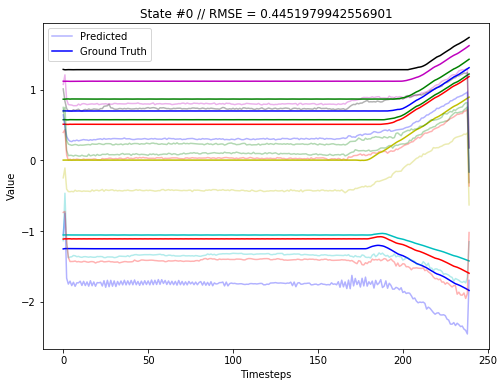

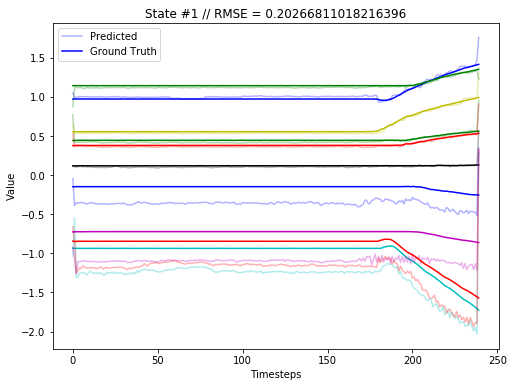

In [35]:
pred, actual = training.rollout_kf(ekf, eval_trajectories, true_initial=True, init_state_noise=0.2)
training.eval_rollout(pred, actual, plot=True)

(10, 240, 2)


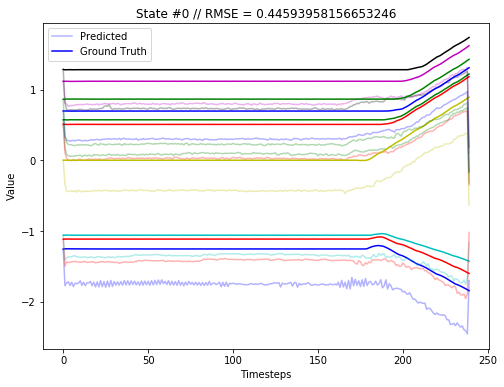

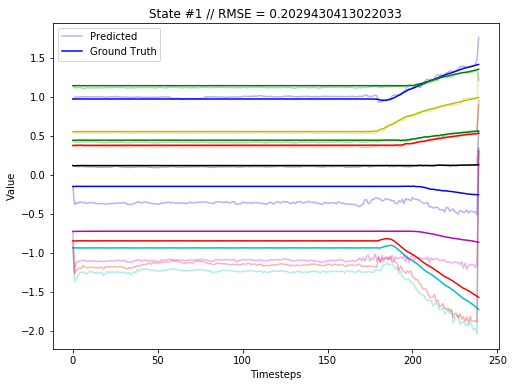

In [38]:
pred, actual = training.rollout_kf(ekf, eval_trajectories, true_initial=True, init_state_noise=0.0)
training.eval_rollout(pred, actual, plot=True)